In [1]:
from itertools import combinations, combinations_with_replacement, product

import tskit
import msprime
import numpy as np

In [2]:
Ne = 10_000
mu = 2e-8
r = 5e-4

In [3]:
ts = msprime.sim_ancestry(samples=4, recombination_rate=0.2, sequence_length=10, random_seed=1)

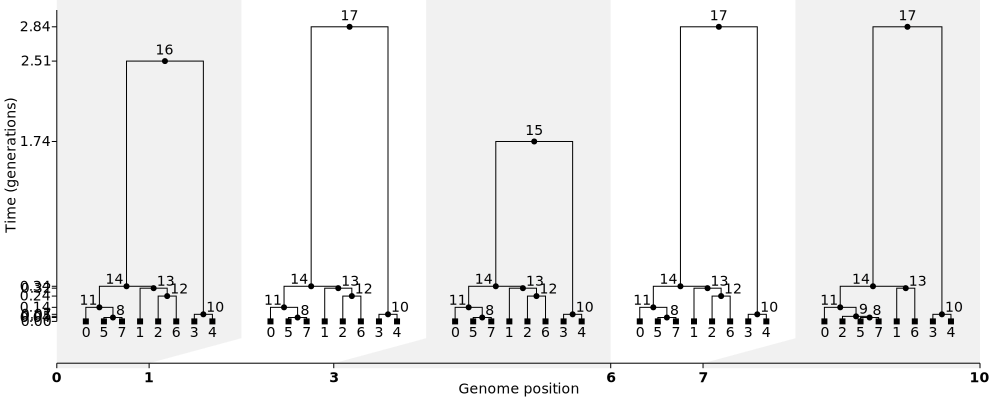

In [4]:
ts.draw_svg(y_axis=True, size=(1000,400))

In [5]:
## TODO: Get rid of sorting in indexing!!

def compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu):
    E_ijij = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, j]))] for i, j in ij]) 
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    D2 = E_ijij - 2 * E_ijik + E_ijkl
    return D2 * (mu ** 2)

def compute_pi2(left_tmrca, right_tmrca, ijkl, mu):
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return E_ijkl * (mu ** 2)

def compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu):
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return 4 * (E_ijik - E_ijkl) * (mu ** 2)

In [14]:
def get_tmrcas(node_times, num_samples, num_nodes, samples_under_nodes):
    tmrcas = {(i, j): tskit.NULL for i, j in combinations(range(num_samples), 2)}
    n = num_nodes - 1
    while num_samples - 1 < n:
        if samples := samples_under_nodes[n]:
            # print(n, samples)
            for s1, s2 in combinations(sorted(samples), 2):  # I don't think we'll need to sort in c
                tmrcas[s1, s2] = node_times[n]
        n -= 1
    return tmrcas

In [15]:
def iter_tree_tmrca(ts):
    samples_under_nodes = [set() for _ in range(ts.num_nodes)]
    parents = [tskit.NULL] * ts.num_nodes

    for s in ts.samples():
        samples_under_nodes[s].add(s)

    edges_out = ts.indexes_edge_removal_order
    edges_in = ts.indexes_edge_insertion_order

    tj, tk, t_left, tree_index, window_index = 0, 0, 0, 0, 0

    while tj < ts.num_edges or t_left < ts.sequence_length:
        while tk < ts.num_edges and ts.edges_right[edges_out[tk]] == t_left:
            e = edges_out[tk]
            tk += 1
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            while parent != tskit.NULL:
                samples_under_nodes[parent] -= samples_under_nodes[child]
                parent = parents[parent]
            parents[child] = tskit.NULL

        while tj < ts.num_edges and ts.edges_left[edges_in[tj]] == t_left:
            e = edges_in[tj]
            tj += 1
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            parents[child] = parent
            while parent != tskit.NULL:
                samples_under_nodes[parent] |= samples_under_nodes[child]
                parent = parents[parent]

        t_right = ts.sequence_length
        if tj < ts.num_edges:
            t_right = min(t_right, ts.edges_left[edges_in[tj]])
        if tk < ts.num_edges:
            t_right = min(t_right, ts.edges_right[edges_out[tk]])

        yield get_tmrcas(ts.nodes_time, ts.num_samples, ts.num_nodes, samples_under_nodes)

        tree_index += 1
        t_left = t_right

In [16]:
def combine(num_samples):
    ij = list(combinations(range(num_samples), 2))
    ijk = [(i, j, k) for i, j, k in product(range(num_samples), repeat=3)
           if i != k and i != j and j != k]
    ijkl = [(i, j, k, l) for i, j in combinations(range(num_samples), 2)
            for k in range(num_samples)
            for l in range(k + 1, num_samples)
            if i != k and j != k and l != i and l != j]
    return ij, ijk, ijkl

In [17]:
def compute_three_stats(ts):
    ij, ijk, ijkl = combine(ts.num_samples)
    D2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    Dz = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    pi2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    for (i, left_tmrca), (j, right_tmrca) in combinations_with_replacement(enumerate(iter_tree_tmrca(ts)), 2):
        D2[i, j] = compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu)
        Dz[i, j] = compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu)
        pi2[i, j] = compute_pi2(left_tmrca, right_tmrca, ijkl, mu)

    tri_idx = np.tril_indices(ts.num_trees, k=-1)
    D2[tri_idx] = D2.T[tri_idx]
    Dz[tri_idx] = Dz.T[tri_idx]
    pi2[tri_idx] = pi2.T[tri_idx]
    return D2, Dz, pi2

In [18]:
compute_three_stats(ts)

(array([[3.14290255e-16, 3.58528306e-16, 2.10583334e-16, 3.58528306e-16,
         3.60362068e-16],
        [3.58528306e-16, 4.09032065e-16, 2.40132736e-16, 4.09032065e-16,
         4.11289077e-16],
        [2.10583334e-16, 2.40132736e-16, 1.41310899e-16, 2.40132736e-16,
         2.40974274e-16],
        [3.58528306e-16, 4.09032065e-16, 2.40132736e-16, 4.09032065e-16,
         4.11289077e-16],
        [3.60362068e-16, 4.11289077e-16, 2.40974274e-16, 4.11289077e-16,
         4.16130932e-16]]),
 array([[5.14017887e-16, 5.94365537e-16, 3.25659512e-16, 5.94365537e-16,
         6.12104059e-16],
        [5.94365537e-16, 6.87244603e-16, 3.76629864e-16, 6.87244603e-16,
         7.07522628e-16],
        [3.25659512e-16, 3.76629864e-16, 2.06170110e-16, 3.76629864e-16,
         3.88415045e-16],
        [5.94365537e-16, 6.87244603e-16, 3.76629864e-16, 6.87244603e-16,
         7.07522628e-16],
        [6.12104059e-16, 7.07522628e-16, 3.88415045e-16, 7.07522628e-16,
         7.28900102e-16]]),
 array

In [19]:
ij, ijk, ijkl = combine(ts.num_samples)
tmrca_iter = iter_tree_tmrca(ts)
left_tmrca = next(tmrca_iter)
right_tmrca = next(tmrca_iter)
print(compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu))
print(compute_pi2(left_tmrca, right_tmrca, ijkl, mu))
print(compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu))

3.585283063381151e-16
5.894473959027726e-16
5.943655372915129e-16


In [ ]:
while True:
    tss = msprime.sim_ancestry(
        samples=2,
        population_size=Ne,
        recombination_rate=r,
        sequence_length=2,
        num_replicates=1_000_000,
        # num_replicates=100_000,
    )
    stats = []
    for ts in tss:
        if ts.num_trees != 2:
            continue
        ij, ijk, ijkl = combine(ts.num_samples)
        tmrca_iter = iter_tree_tmrca(ts)
        left_tmrca = next(tmrca_iter)
        right_tmrca = next(tmrca_iter)
        stats.append([
            compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu),
            compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu),
            compute_pi2(left_tmrca, right_tmrca, ijkl, mu),
        ])
    print(np.mean(stats, 0))

[7.14842593e-09 1.57868652e-09 1.60908378e-07]
[7.17845817e-09 1.89565847e-09 1.61250924e-07]
[7.02855344e-09 1.98200419e-09 1.61074519e-07]
[7.16584828e-09 1.67705245e-09 1.60951059e-07]
[7.03535355e-09 2.15296542e-09 1.60914781e-07]
[7.21155728e-09 1.51397000e-09 1.61311711e-07]
[7.14228342e-09 1.77260653e-09 1.61084336e-07]
[7.06472485e-09 2.11056258e-09 1.60982011e-07]
[7.09675276e-09 1.88687896e-09 1.61171022e-07]
[7.07247367e-09 1.91471623e-09 1.61155946e-07]
[7.18088485e-09 1.44675666e-09 1.61254635e-07]
[7.24703947e-09 1.66475467e-09 1.61184735e-07]
[7.02823829e-09 2.09747152e-09 1.60925745e-07]
[7.18047223e-09 1.70446664e-09 1.61213620e-07]
[7.03505821e-09 1.78958347e-09 1.61016794e-07]
[7.06682587e-09 1.79561124e-09 1.61106173e-07]
[6.96178781e-09 2.20290788e-09 1.60780850e-07]
[7.08486749e-09 1.52374836e-09 1.60953503e-07]
[6.96456234e-09 2.23092125e-09 1.60981387e-07]
[7.12782398e-09 1.70580552e-09 1.60932309e-07]
[7.04125196e-09 1.73967146e-09 1.61044995e-07]
[7.07307512e-

In [20]:
iter_mrca = iter_tree_mrca(ts)

In [21]:
mrcas = next(iter_mrca)

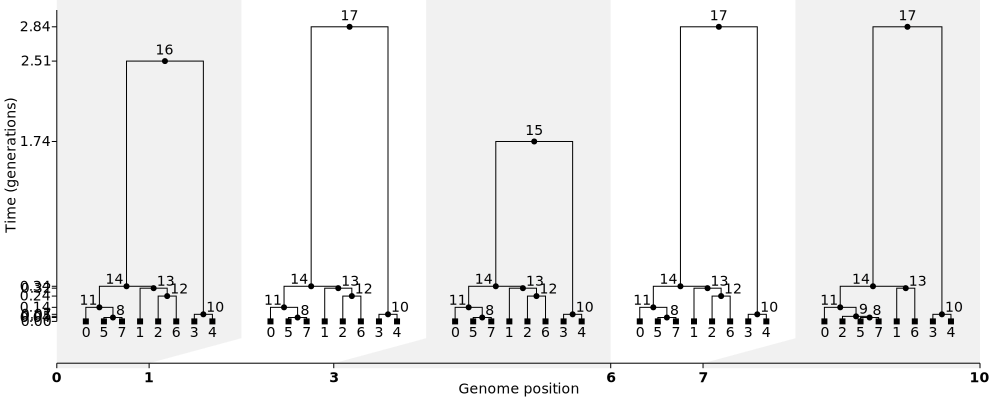

In [4]:
ts.draw_svg(y_axis=True, size=(1000,400))

In [22]:
mrcas

{(0, 1): 14,
 (0, 2): 14,
 (0, 3): 16,
 (0, 4): 16,
 (0, 5): 11,
 (0, 6): 14,
 (0, 7): 11,
 (1, 2): 13,
 (1, 3): 16,
 (1, 4): 16,
 (1, 5): 14,
 (1, 6): 13,
 (1, 7): 14,
 (2, 3): 16,
 (2, 4): 16,
 (2, 5): 14,
 (2, 6): 12,
 (2, 7): 14,
 (3, 4): 10,
 (3, 5): 16,
 (3, 6): 16,
 (3, 7): 16,
 (4, 5): 16,
 (4, 6): 16,
 (4, 7): 16,
 (5, 6): 14,
 (5, 7): 8,
 (6, 7): 14}